# Test of ADMM + DnCNN
let's denoise sar image.
using CNN as a step of the ADMM

In [1]:
import scipy
import numpy as np
import tensorflow as tf
from model import denoiser
from utils_train import *
import scipy.misc
import matplotlib.pyplot as plt
import imz2mat
import utils
import ADMM
%matplotlib inline

In [2]:
# This function is now in utils
def debiased(L):
    return np.log(L)-scipy.special.digamma(L)

In [3]:
# We then run a session tf(WARNING : execute once)
# Don't forget to close
sess = tf.Session()
model = denoiser(sess, sigma=25, add_noise=False)

[*] Initialize model successfully...


/cluster/storage/shorache/.conda/envs/bestenv/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':


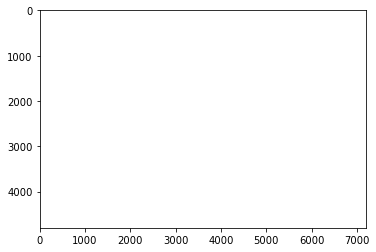

In [4]:
img = scipy.misc.imread("data/test/test.png")
plt.imshow(img)

imz2mat : version Septembre 2017
Dans ximaread : image monocanal
Dans ximaread : lecture du canal 0/1
image en .imf
image en .imf
('image en float', 1024, ' ', 1024, '  canaux:', 1, ' verif : ', 0)
('lecture de ', 'data/PileSaintGervais_moyennearithmetique.imf', ' en quelconque', 1024, 1024, 1, ' offset ', 0, '>f', 4, ' complex', 0, 'blocksize', 4194304)
Données réelles. Nouvelle version de imz2mat  >f
39468.7600957


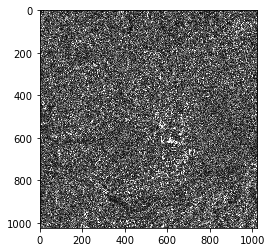

In [5]:
# load the ground truth
img_gt = imz2mat.imz2mat('data/PileSaintGervais_moyennearithmetique.imf')[0].astype(np.float32)
L=1
img_speckle = utils.addSARnoise(img_gt, L=L)


# psnr very low
img_gt_log = np.log(1+img_gt)
#img_gt_log = utils.robust_scale(img_gt, normal=False).astype(np.float32)
#img_in = utils.robust_scale(img_speckle, normal=False).astype(np.float32)
img_in = np.log(1+img_speckle)
#im1 = imz2mat.imz2mat('data/SAINTGERVAIS/pilesaintgervaisF.ima')
#img_in = np.log(1+np.abs(im1[0][:,:,0])**2)
#print(cal_psnr(img_gt_log, img_in))
print(cal_mse(np.exp(img_gt_log)-1, np.exp(img_in)-1))
utils.displayRSO(np.sqrt(img_speckle))


In [6]:
# load the weights here for sigma=25
ckpt_dir = "./checkpoint_sar"
model.load(ckpt_dir)

[*] Reading checkpoint...
INFO:tensorflow:Restoring parameters from ./checkpoint_sar/DnCNN-tensorflow-50650


(True, 50650)

8772.66813912


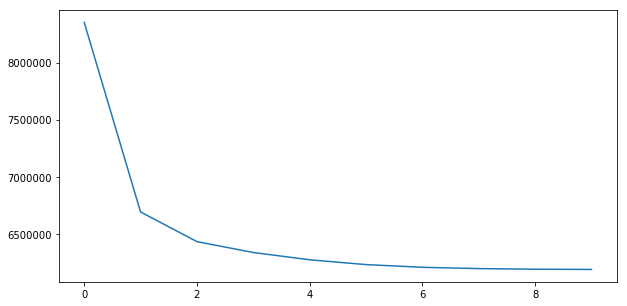

In [7]:
# Test admm alone
out, E = ADMM.ADMM(img_in, beta = 0.7,lamb = 1,niter = 10)
plt.figure(figsize=(10,5))
plt.plot(E)
#out = out + debiased(L)
#print(cal_psnr(img_gt_log, out))
print(cal_mse(np.exp(img_gt_log)-1, np.exp(out)-1))

In [8]:
# Test DnCNN
C = np.max(img_in)-np.min(img_in)
b = img_in.min()/C
img_inp = img_in/C - b
img_input = img_inp.reshape(1, img_in.shape[1], img_in.shape[0],1)
out2, _, _ = model.denoise(img_input)
out2 = out2.reshape(img_in.shape)
out2 = C*(out2+b)
out2 = out2 + debiased(L)
print(cal_mse(np.exp(img_gt_log)-1, np.exp(out2)-1))

10761.603701


7479.13061631


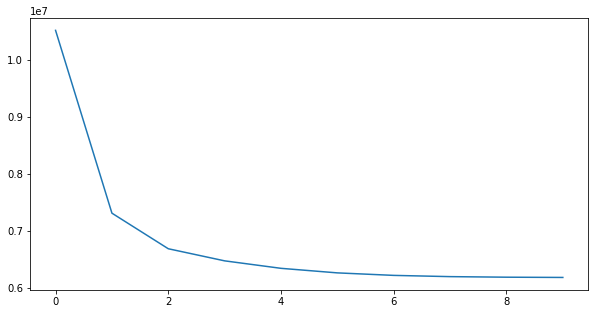

In [9]:
# We mixed both
out3, E = ADMM.ADMM(img_in, beta = 2,lamb = 1,niter = 10, CNNprior=model)
plt.figure(figsize=(10,5))
plt.plot(E)
#out3 = out3 + debiased(L)
print(cal_mse(np.exp(img_gt_log)-1, np.exp(out3)-1))

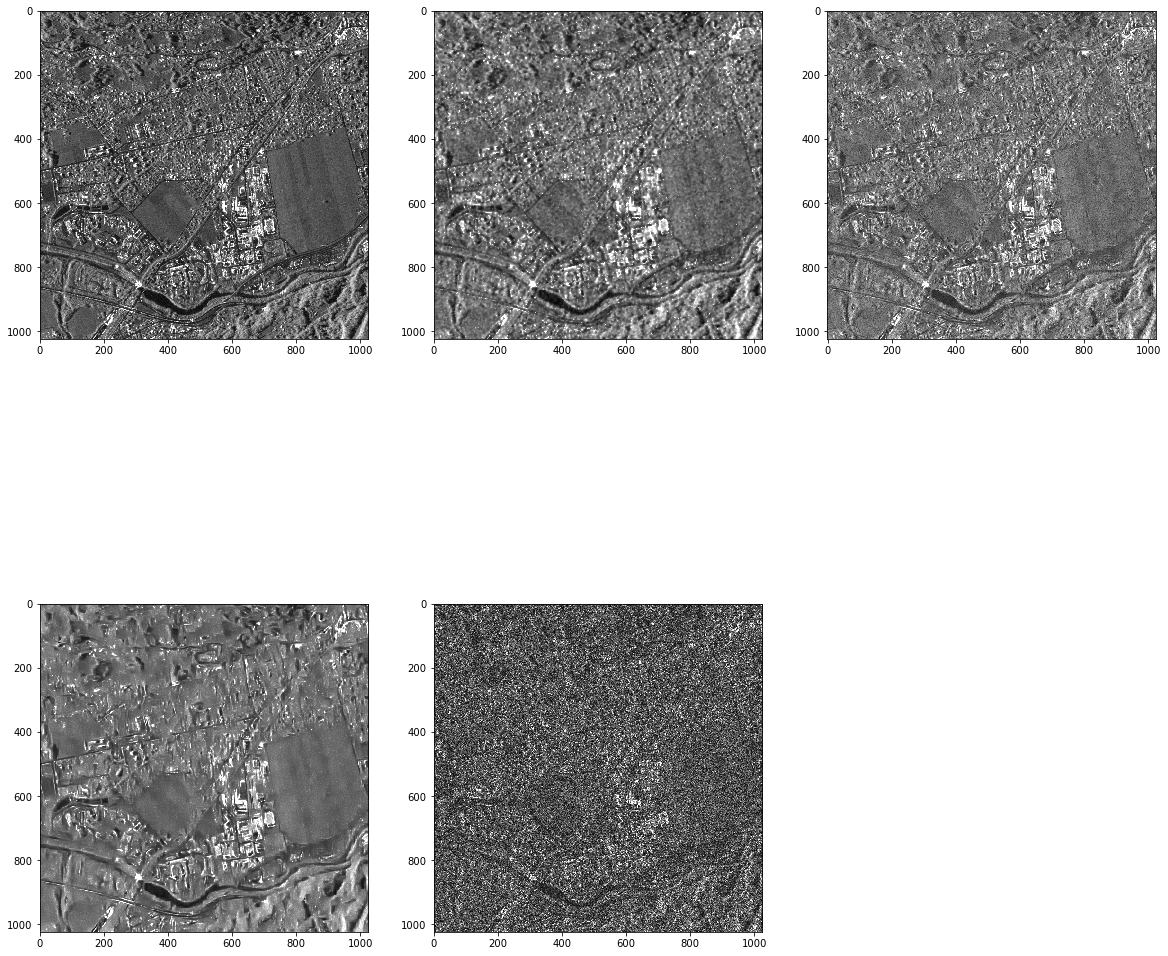

In [10]:
#display the result
plt.figure(figsize=(20,20))
plt.subplot(231)
utils.displayRSO(np.sqrt(np.exp(img_gt_log)-1))
plt.subplot(232)
utils.displayRSO(np.sqrt(np.exp(out)-1))
plt.subplot(233)
utils.displayRSO(np.sqrt(np.exp(out2)-1))
plt.subplot(234)
utils.displayRSO(np.sqrt(np.exp(out3)-1))
plt.subplot(235)
utils.displayRSO(np.sqrt(np.exp(img_in)-1))

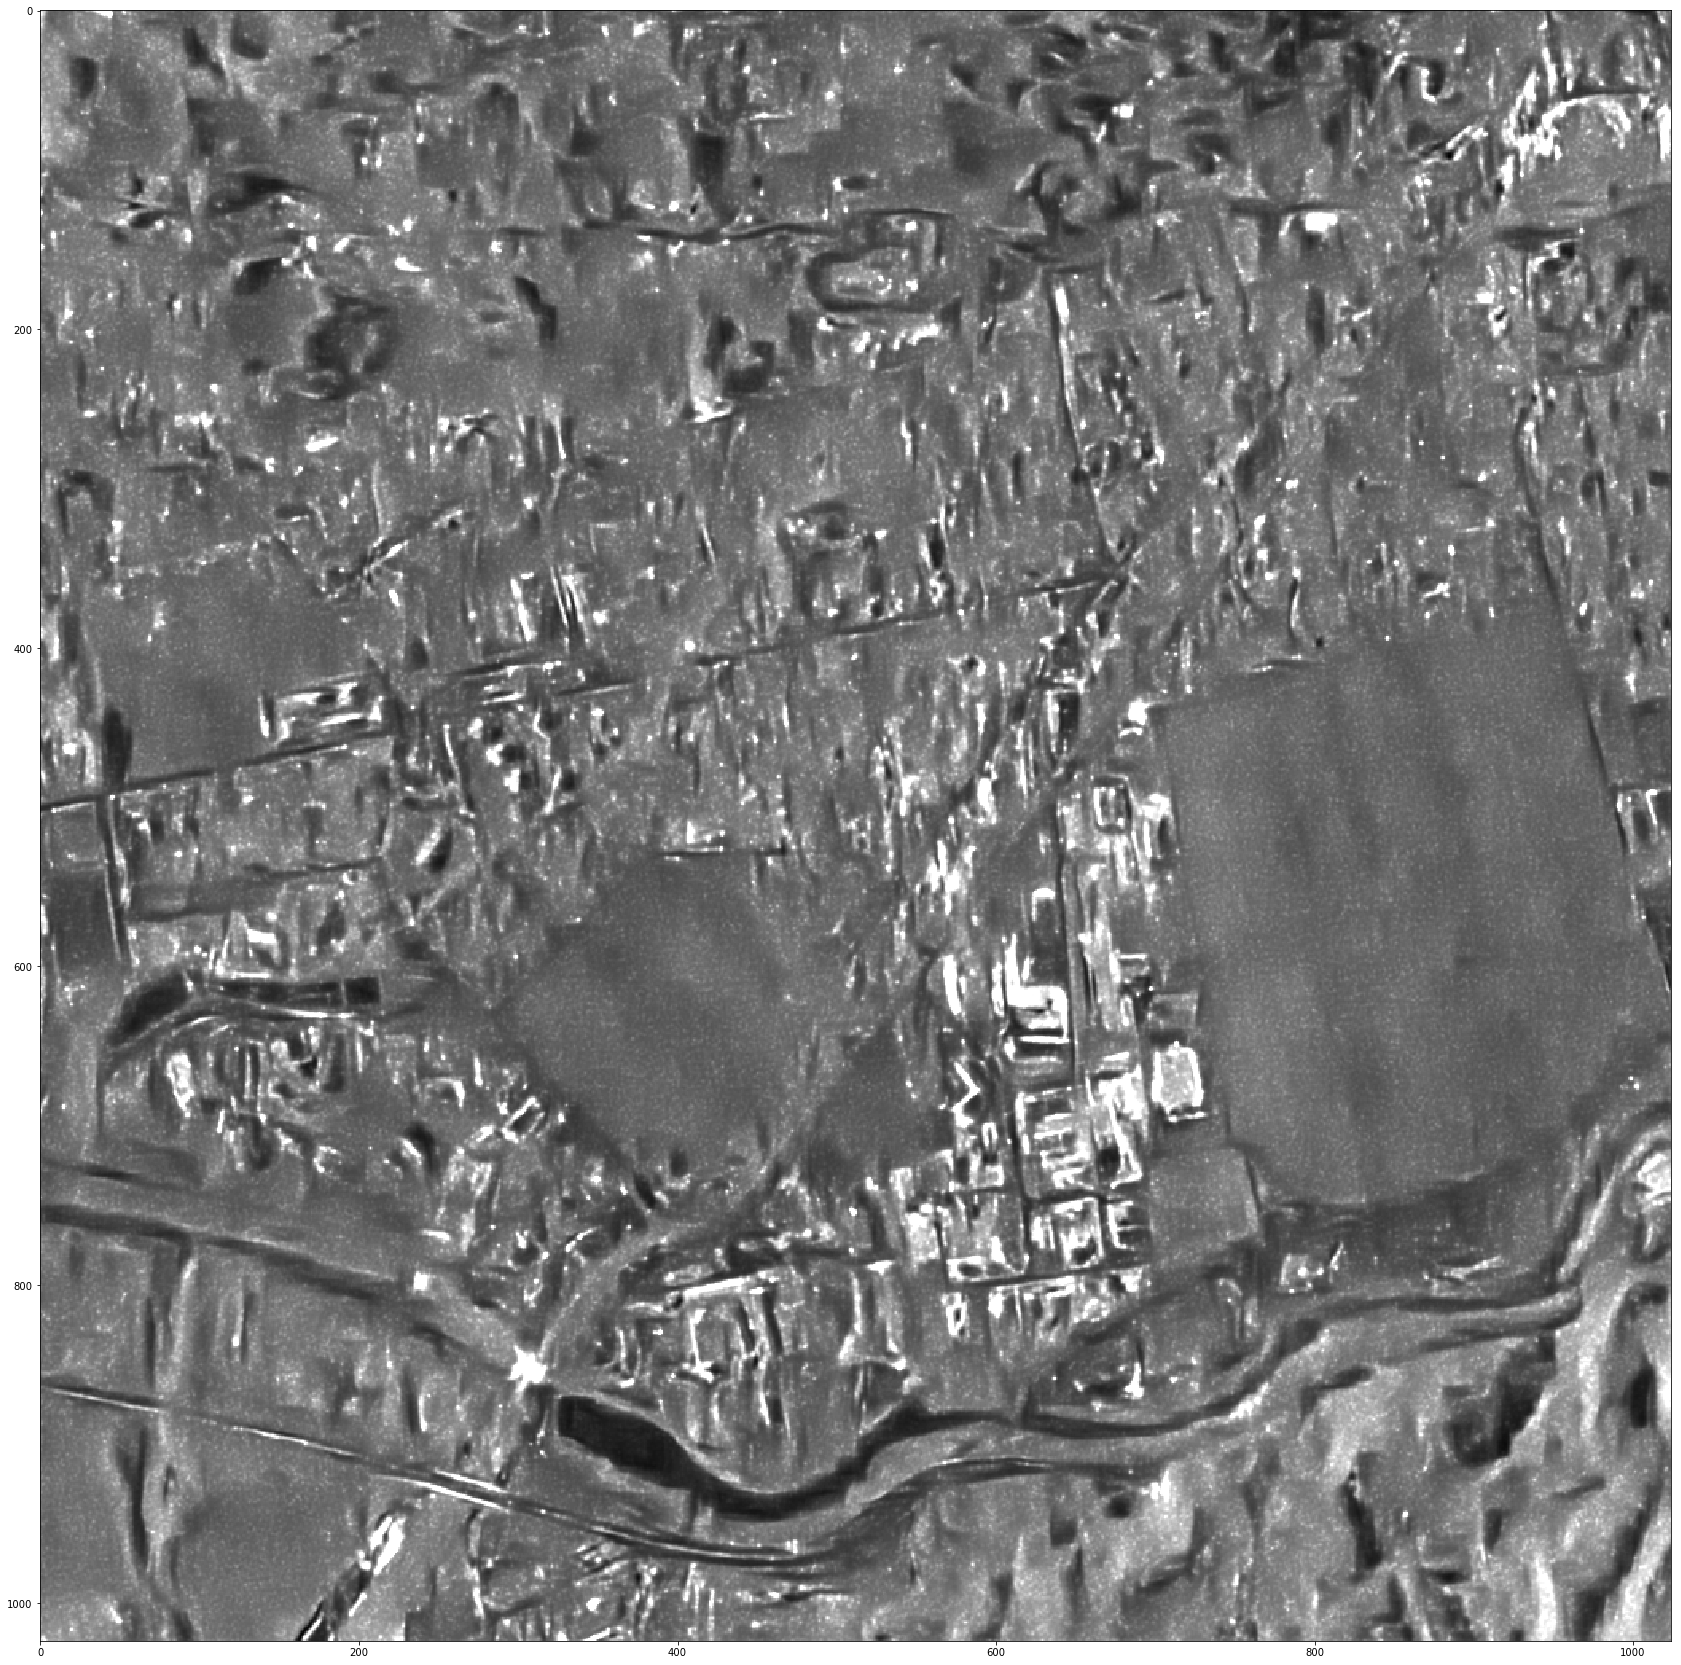

In [14]:
plt.figure(figsize=(30,30))
#plt.subplot(121)
utils.displayRSO(np.sqrt(np.exp(out3)-1))
#plt.subplot(122)
#utils.displayRSO(np.sqrt(np.exp(out)-1))

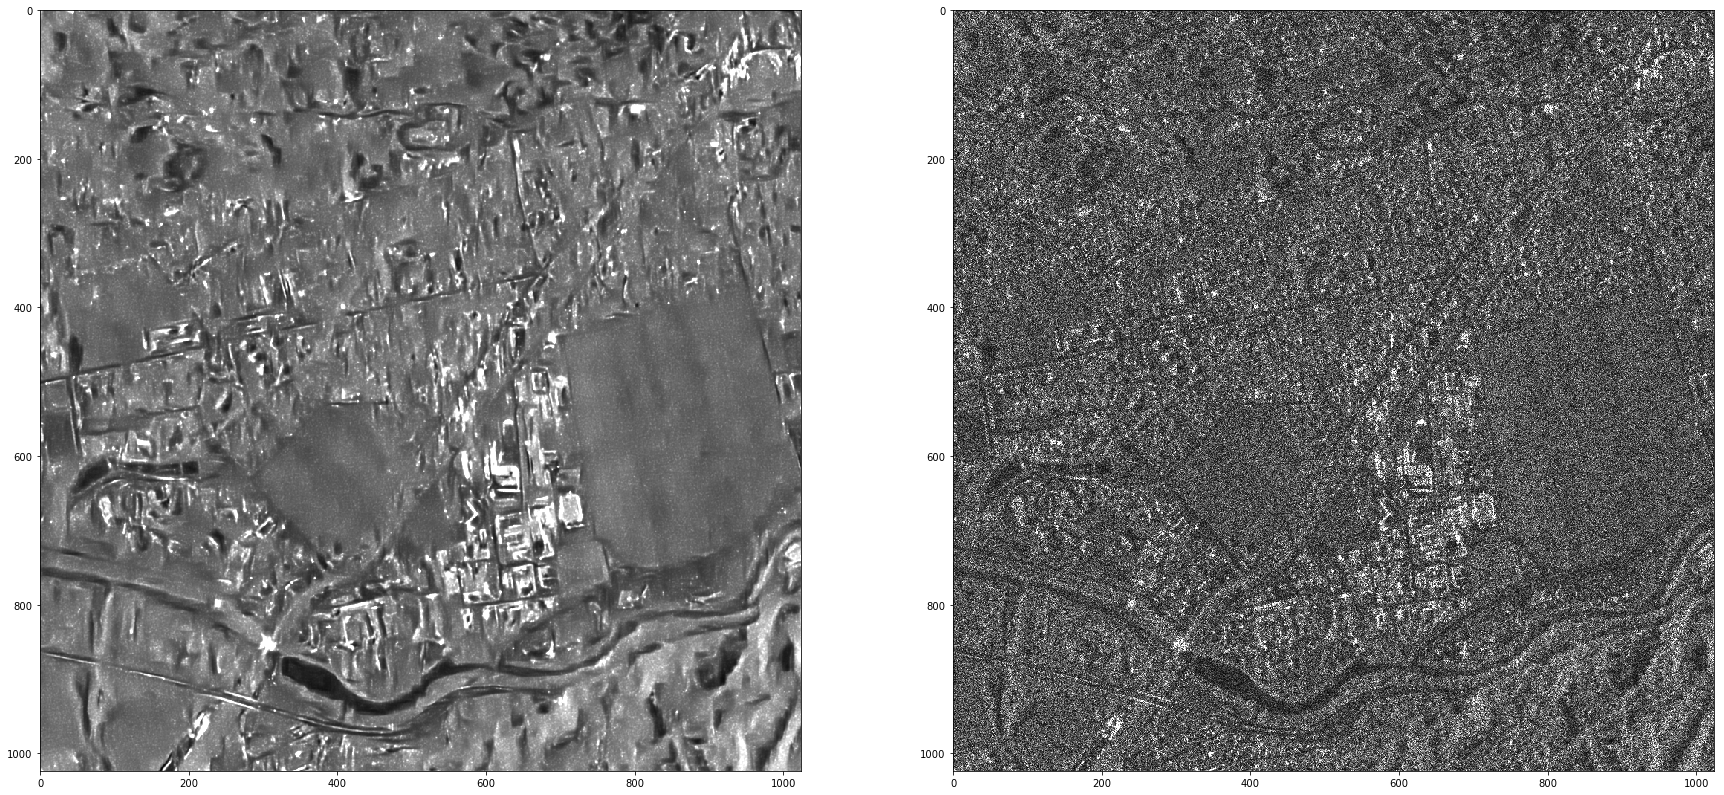

In [12]:
plt.figure(figsize=(30,30))
plt.subplot(121)
utils.displayRSO(np.sqrt(np.exp(out3)-1))
plt.subplot(122)
utils.displayRSO(np.sqrt(np.exp(img_in)-1))

In [13]:
print(scipy.special.polygamma(3,1))
sess.close()

6.49393940227
